In [57]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from fbprophet import Prophet

In [58]:
df = pd.read_csv('../data/orders.csv', parse_dates=[5,6],sep=';',low_memory=False)


In [60]:
from datetime import timedelta
df['weekday'] = df['First Opened'].dt.weekday
df['week'] = df['First Opened'].dt.week
df['week_start'] = df['First Opened'].dt.to_period('W').apply(lambda r: r.start_time)-timedelta(days=1)
df['hour'] = df['First Opened'].dt.hour
df['date']= pd.to_datetime(df['First Opened'].dt.date)
df=df[df['weekday']!=6]
df['sales'] = df['Final Total']
df=df[['date','week_start','weekday','sales','hour']]

Ticket medio

In [61]:
df['sales'].mean()

7.605444355484321

In [62]:
#daily = df.groupby(['date','product_name']).count()['product_quantity'].reset_index()
daily_count = df.groupby(['date']).count()['sales'].reset_index()
daily_sales = df.groupby(['date']).sum()['sales'].reset_index()

In [63]:
weekly_count = df.groupby(['week_start']).count()['sales'].reset_index()
weekly_sales = df.groupby(['week_start']).sum()['sales'].reset_index()

Numero medio de tickets diarios 

In [64]:
daily_count['sales'].mean()

76.46938775510205

Perfil horario de tickets

In [80]:
hourly = df.groupby(['date','hour']).count().reset_index()[['date','hour','sales']]

In [83]:
hourly_mean = hourly.groupby('hour').mean().reset_index()[['hour','sales']]

<BarContainer object of 546 artists>

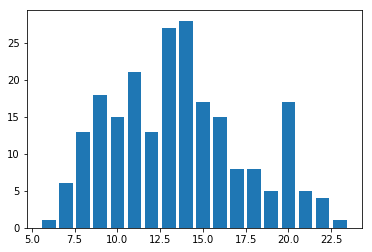

In [84]:
plt.bar(hourly['hour'],hourly['sales'])

Perfil medio de tickets vendidos por hora

<BarContainer object of 18 artists>

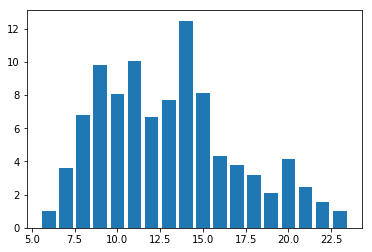

In [86]:
plt.bar(hourly_mean['hour'],hourly_mean['sales'])

Boxplot horario

In [88]:
groups = hourly.groupby(hourly['hour'])['sales']

(0, 23)

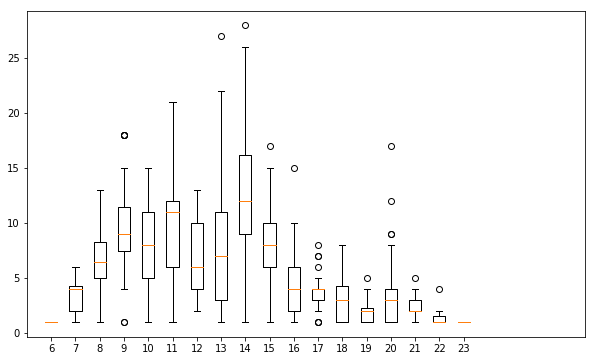

In [93]:
f = plt.figure(figsize=(10,6))
hours = []
delays = []
for label,group in groups:
    hours.append(label)
    delays.append(group)
    
plt.boxplot(delays, labels=hours)
plt.xlim(0,23)

In [95]:
train_df = daily_count[daily_count['date'] <= datetime.date(2019,2,3)]
test_df = daily_count[daily_count['date'] >= datetime.date(2019,2,3)]

/usr/local/dsc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  """Entry point for launching an IPython kernel.
/usr/local/dsc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  


In [99]:
#dsY = daily[daily['product_name']=='Agua de Hibisco']
dsY = train_df
renamed = dsY.rename(index=str,columns={'date':'ds', 'sales': 'y'})

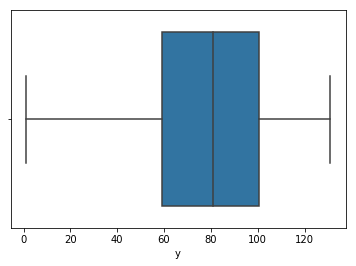

In [100]:
import seaborn as sns
sns.boxplot(x=renamed['y'])

In [101]:
from scipy import stats
import numpy as np

In [102]:
Q1 = renamed.quantile(0.25)
Q3 = renamed.quantile(0.75)
IQR = Q3 - Q1

outlierUp = Q3 + 1.5 * IQR
outlierDown = Q1 - 1.5 * IQR

print(outlierUp, outlierDown)

y    162.75
dtype: float64 y   -3.25
dtype: float64


In [103]:
# Quitar outliers
renamed = renamed[(renamed['y'] < outlierUp.y) & (renamed['y'] > outlierDown.y)]

In [108]:
m = Prophet(yearly_seasonality=True,daily_seasonality=False)
m.fit(renamed)

/usr/local/dsc/anaconda3/lib/python3.7/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
/usr/local/dsc/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [138]:
future = m.make_future_dataframe(periods=14)
#future.tail()

In [139]:
forecast = m.predict(future)
#forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

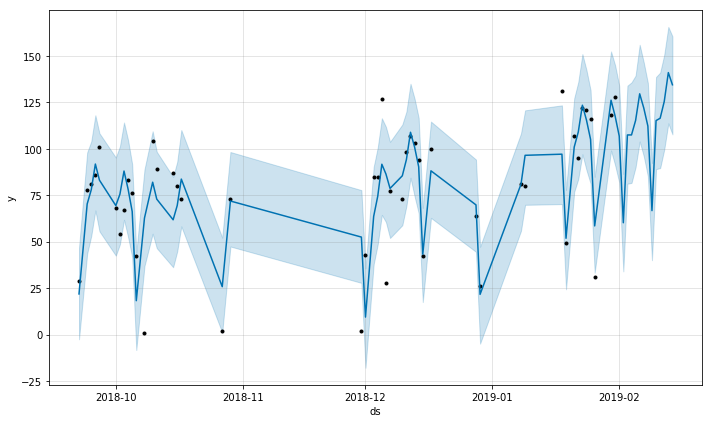

In [140]:
fig1 = m.plot(forecast)

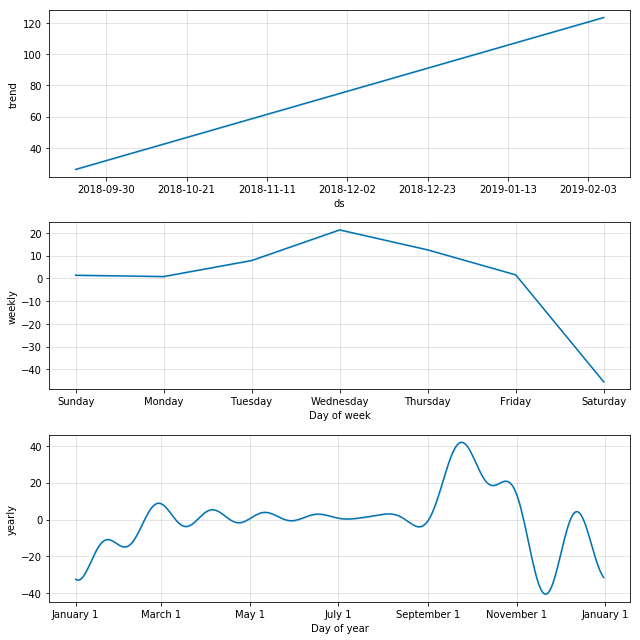

In [125]:
fig2 = m.plot_components(forecast)

nan nan


/usr/local/dsc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


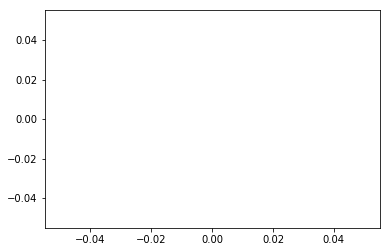

In [141]:
from functools import reduce

def errorEstimation(forecast, test):
    validate = pd.merge(forecast,test,how='inner',left_on='ds',right_on='date')

    validate['dif'] = validate['yhat'] - validate['sales']
    validate['difp'] = (validate['dif']*100) / validate['sales']
    validate['rms'] = validate['dif'].map(lambda x: x**2)
    
    meanDiff = validate['difp'].mean()
    rms = validate['rms'].sum()/validate['rms'].count()
    
    print(rms**.5, meanDiff)
    
    return validate[['date','dif','rms','difp','sales','yhat','yhat_lower','yhat_upper']]
    

errors=errorEstimation(forecast[forecast['ds'] > min(test_df['date'])],test_df)

plt.plot(errors['difp'])

Timestamp('2019-02-14 00:00:00')

In [127]:
errors[['date','yhat','sales','difp']]

,date,yhat,sales,difp


In [128]:
train_df.tail()

,date,sales
42,2019-01-24,121
43,2019-01-25,116
44,2019-01-26,31
45,2019-01-30,118
46,2019-01-31,128


In [129]:
test_df

,date,sales
47,2019-03-08,99
48,2019-03-09,41


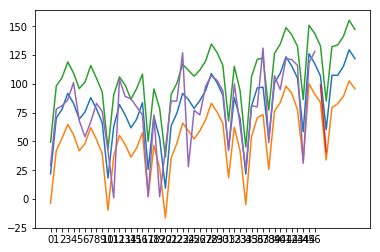

In [132]:
plt.plot(forecast['yhat'])

plt.plot(forecast['yhat_lower'])

plt.plot(forecast['yhat_upper'])

plt.plot(test_df['sales'])
plt.plot(renamed['y'])
